In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal as ss
import h5py
import os

from analysis import plot

### Trial settings

In [2]:
setting_properties = ['duration_window', 'psd_segment_length']
settings = {
    'drifting_grating': [
        {'baseline': (.1,  .5), 'drifting_grating': (.5, 3.)}, # seconds
        {'baseline': 0.4, 'drifting_grating': 0.5} # seconds
    ],
    'movie_5s': [
        {'movie': (0.,  3.)},
        {'movie': 0.5}
    ]
}
settings = pd.DataFrame.from_dict(settings, orient='index', columns=setting_properties)
settings

,duration_window,psd_segment_length
drifting_grating,"{'baseline': (0.1, 0.5), 'drifting_grating': (...","{'baseline': 0.4, 'drifting_grating': 0.5}"
movie_5s,"{'movie': (0.0, 3.0)}",{'movie': 0.5}


#### Common parameters

In [3]:
params = dict(
    channel_id = 3, # layer 5
    fooof_params = dict(aperiodic_mode='knee', plt_range=100., freq_range=200., plt_log=True),
    scalogram_params = dict(downsample_fs=1000., plt_log=True, remove_aperiodic=False, clr_freq_range=None),
)

#### Select trial

In [4]:
trial_name = 'output_drifting'
setting_name = 'drifting_grating'

# trial_name = 'output_movie_5s'
# setting_name = 'movie_5s'

setting = settings.loc[setting_name]

### File paths

In [5]:
output_dir = os.path.join('..', 'V1_bio_outputs', trial_name)
data_dir = os.path.join('.', 'data')
trial_dir = os.path.join(data_dir, trial_name)

config_file = os.path.join(output_dir, 'config.json')
spikes_file = os.path.join(output_dir, 'spikes.h5')
ecp_file = os.path.join(output_dir, 'ecp.h5')

### Load data

In [6]:
v1_pop_df = pd.read_csv(os.path.join(data_dir, 'v1_population_properties.csv'), index_col='pop_name')

In [7]:
with h5py.File(ecp_file, 'r') as f:
    lfps = xr.DataArray(
        f['ecp']['data'][()].T,
        coords = dict(
            channel_id = f['ecp']['channel_id'][()],
            time = np.arange(*f['ecp']['time']) # ms
        ),
        attrs = dict(
            fs = 1000 / f['ecp']['time'][2] # Hz
        )
    )
display(lfps)

<xarray.DataArray (channel_id: 5, time: 30000)>
array([[4.35842737e-03, 6.93986153e-03, 8.46374209e-03, ...,
        1.07468107e-02, 1.06229797e-02, 1.03406023e-02],
       [2.50889960e-03, 3.74243531e-03, 4.48314112e-03, ...,
        1.11200801e-02, 1.08889098e-02, 1.06152263e-02],
       [9.23583039e-04, 1.55148976e-03, 2.18152849e-03, ...,
        2.74088150e-02, 2.75364814e-02, 2.74308100e-02],
       [2.33040942e-03, 4.41415163e-03, 5.95708661e-03, ...,
        6.59412979e-02, 6.61552520e-02, 6.60484159e-02],
       [4.82511713e-05, 1.48077132e-03, 3.00681768e-03, ...,
        5.51747638e-02, 5.59689128e-02, 5.65628333e-02]])
Coordinates:
  * channel_id  (channel_id) int64 0 1 2 3 4
  * time        (time) float64 0.0 0.1 0.2 0.3 0.4 ... 3e+03 3e+03 3e+03 3e+03
Attributes:
    fs:       10000.0

In [8]:
spike_file = "spike_rate.h5"

with h5py.File(os.path.join(trial_dir, spike_file), 'r') as f:
    pop_rspk = xr.DataArray(
        np.stack([g['data'] for g in f['populations'].values()], axis=0),
        coords = dict(
            population = list(f['populations'].keys()),
            time = np.arange(*f['time'])
        ),
        attrs = dict(
            fs = 1000 / f['time'][2]
        )
    ).to_dataset(name='spike_number', promote_attrs=True)
    pop_rspk = pop_rspk.assign(
        population_number = xr.DataArray(
            [g.attrs['number'] for g in f['populations'].values()],
            coords = dict(
                population = pop_rspk.coords['population']
            )
        )
    )
    pop_rspk = pop_rspk.assign(
        spike_rate = pop_rspk.fs / pop_rspk.population_number * pop_rspk.spike_number
    )
display(pop_rspk)

<xarray.Dataset>
Dimensions:            (population: 34, time: 1500)
Coordinates:
  * population         (population) <U11 'LIFe23' 'LIFe4' ... 'i6Pvalb' 'i6Sst'
  * time               (time) float64 0.0 2.0 4.0 ... 2.996e+03 2.998e+03
Data variables:
    spike_number       (population, time) int64 0 0 0 0 0 0 0 ... 15 14 11 7 7 5
    population_number  (population) int64 43368 35507 25989 ... 192 1052 1059
    spike_rate         (population, time) float64 0.0 0.0 0.0 ... 3.305 2.361
Attributes:
    fs:       500.0

### Plot traces

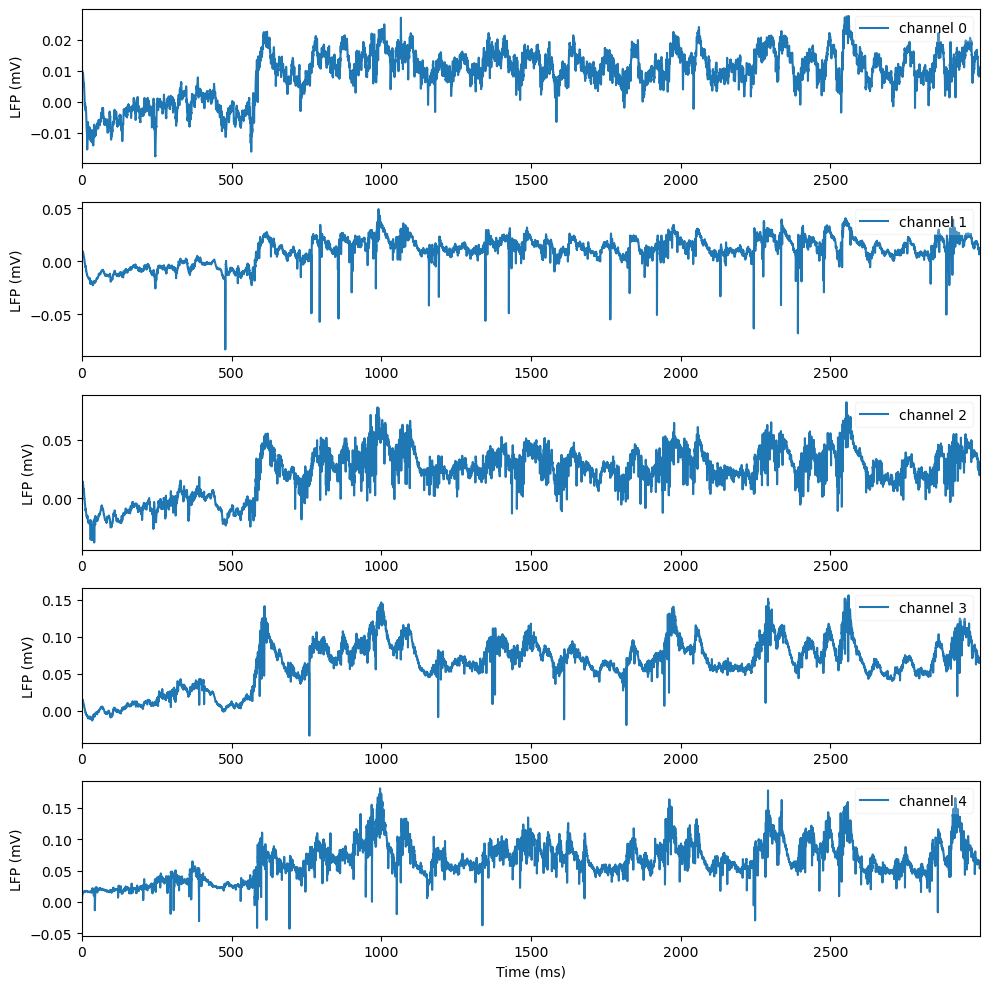

In [9]:
n_channel = lfps.coords['channel_id'].size
_, axs = plt.subplots(n_channel, 1, figsize=(10, 2 * n_channel))
for i, ax in enumerate(axs):
    ax.plot(lfps.time, lfps.isel(channel_id=i), label=f'channel {lfps.channel_id.values[i]:d}')
    ax.set_xlim(lfps.time[[0, -1]])
    ax.legend(loc='upper right', framealpha=0.2)
    ax.set_ylabel('LFP (mV)')
axs[-1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()


In [10]:
layers = v1_pop_df['layer'].unique()
model_types = v1_pop_df['model_type'].unique()[::-1]

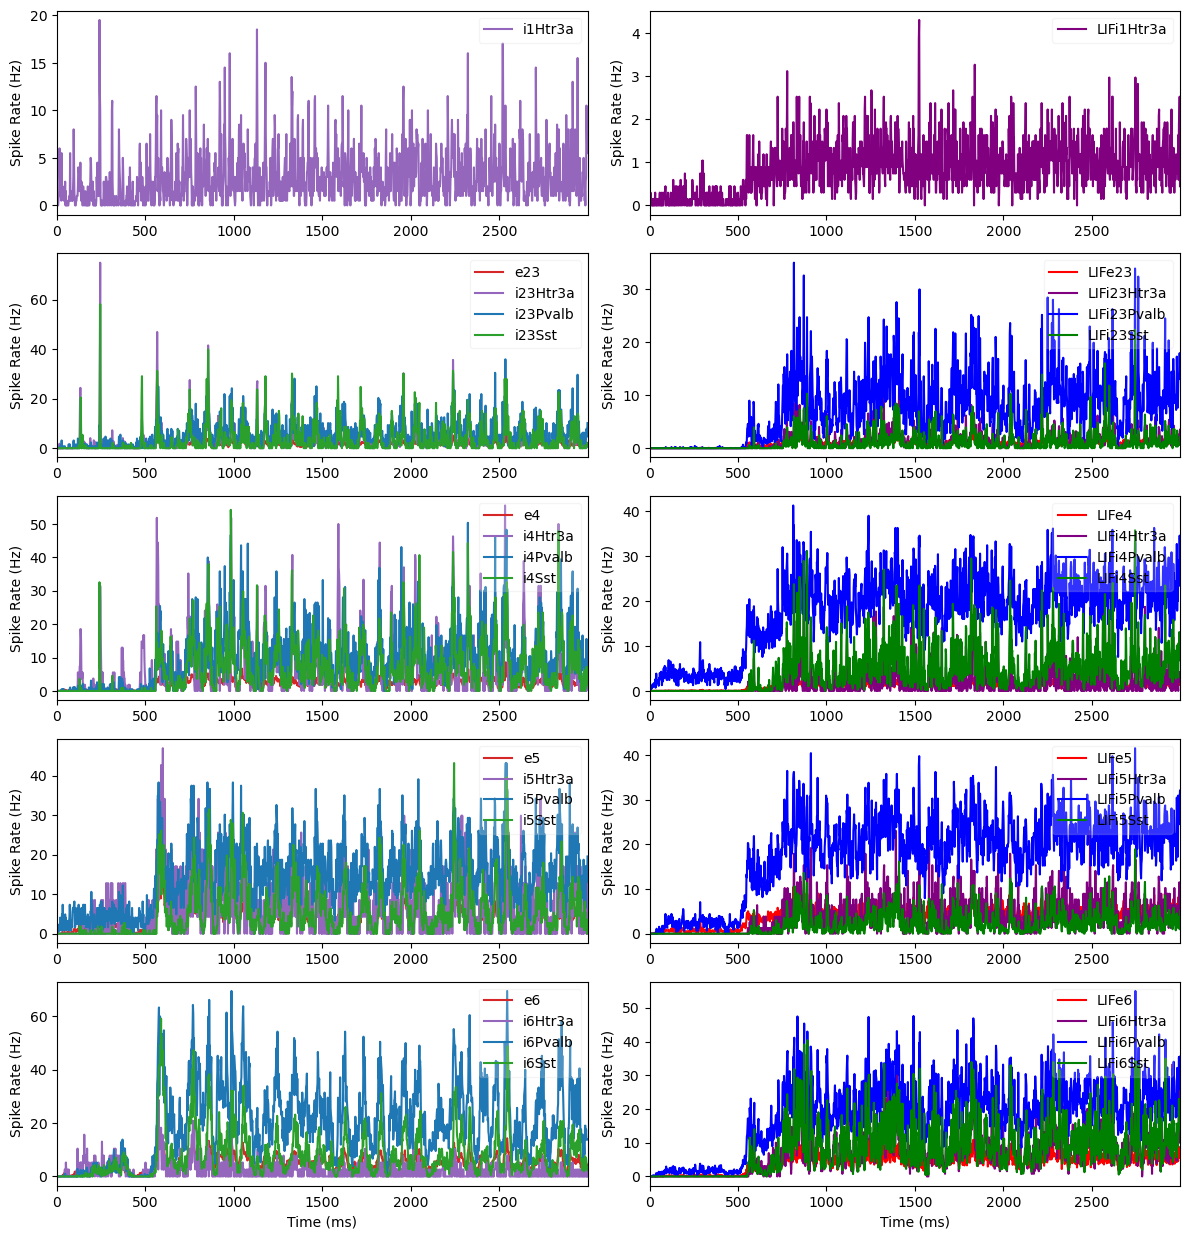

In [11]:
_, axs = plt.subplots(len(layers), 2, figsize=(12, 2.5 * len(layers)))
spike_rate = pop_rspk.spike_rate
for i, L in enumerate(layers):
    for j, M in enumerate(model_types):
        ax = axs[i, j]
        pops = v1_pop_df.index[(v1_pop_df['layer'] == L) & (v1_pop_df['model_type'] == M)]
        for p in pops:
            ax.plot(spike_rate.time, spike_rate.sel(population=p), color=v1_pop_df.loc[p, 'color'], label=p)
        ax.set_xlim(spike_rate.time[[0, -1]])
        ax.legend(loc='upper right', framealpha=0.2)
        ax.set_ylabel('Spike Rate (Hz)')
for ax in axs[-1, :]:
    ax.set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

### PSD of LFP

baseline
Channel:  3
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 5 - 200 Hz                        
                                 Frequency Resolution is 2.50 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -5.5708, -8.3381, 1.3602                                     
                                                                                                  
                                       8 peaks were found:                              

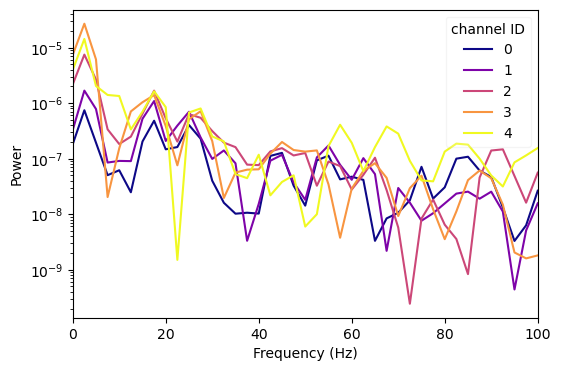

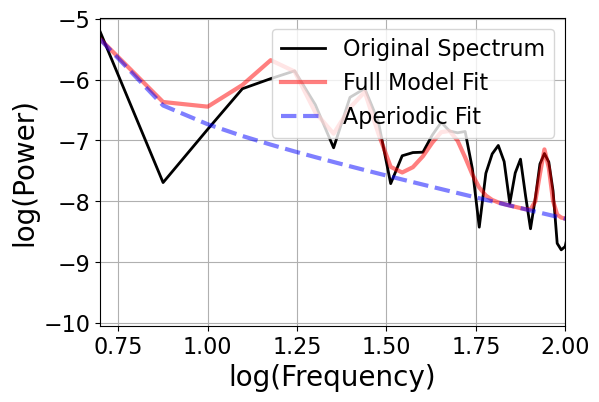

<Figure size 640x480 with 0 Axes>

drifting_grating
Channel:  3
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 4 - 200 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -4.5366, -5.3634, 1.4008                                     
                                                                                                  
                                       6 peaks were found:                      

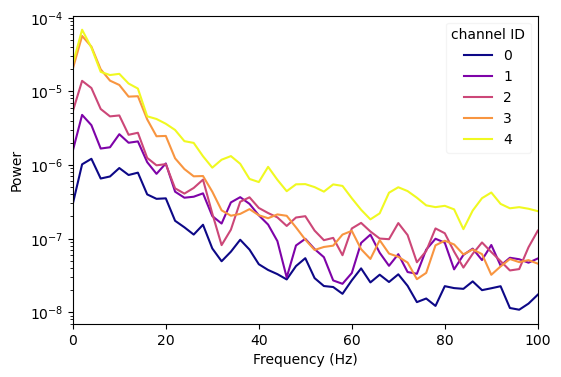

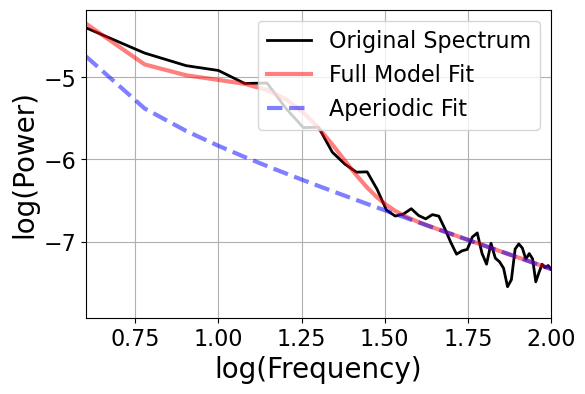

<Figure size 640x480 with 0 Axes>

In [12]:
durations = list(setting.duration_window.keys())
fs = lfps.fs
psd_lfp = {}
for dur in durations:
    print(dur)
    tseg = setting.psd_segment_length[dur]
    time_window = 1000 * np.array(setting.duration_window[dur]) # ms
    f, pxx = ss.welch(lfps.sel(time=slice(*time_window)).values, fs=fs, nperseg=int(tseg * fs))
    psd_lfp[dur] = xr.DataArray(pxx, coords={
        'channel': lfps.channel_id.values, 'frequency': f
    })
    _ = plot.plot_channel_psd(psd_lfp[dur], channel_id=params['channel_id'], **params['fooof_params'], figsize=(6, 4))
    plt.show()

In [13]:
lfp_sxx = {}
for dur in durations:
    tseg = setting.psd_segment_length[dur]
    axis = lfps.dims.index('time')
    lfp_sxx[dur] = plot.cwt_spectrogram_xarray(
        lfps, fs, axis=axis, downsample_fs=params['scalogram_params']['downsample_fs'],
        channel_coords={'channel_id': lfps.channel_id}, freq_range=(1 / tseg, np.inf)
    )

baseline


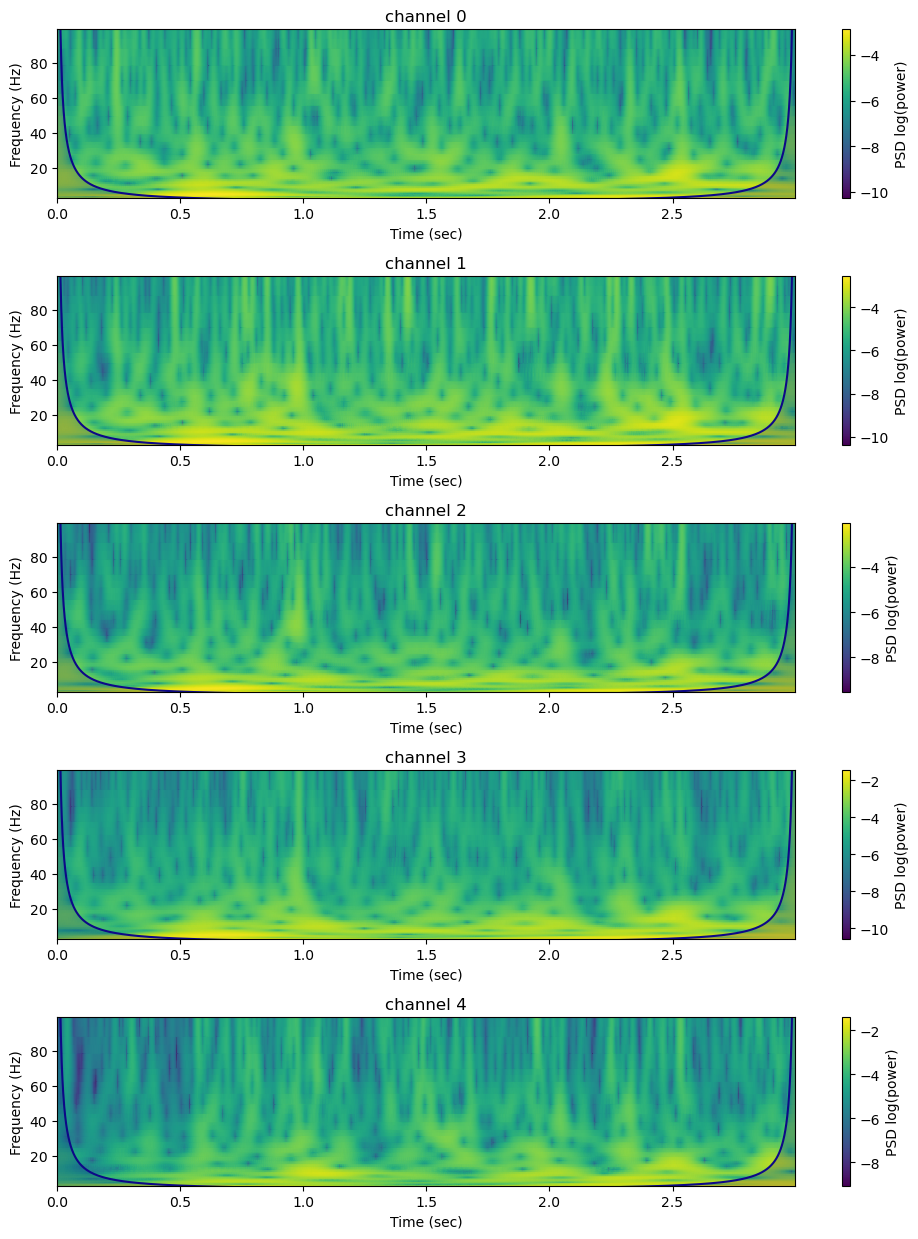

drifting_grating


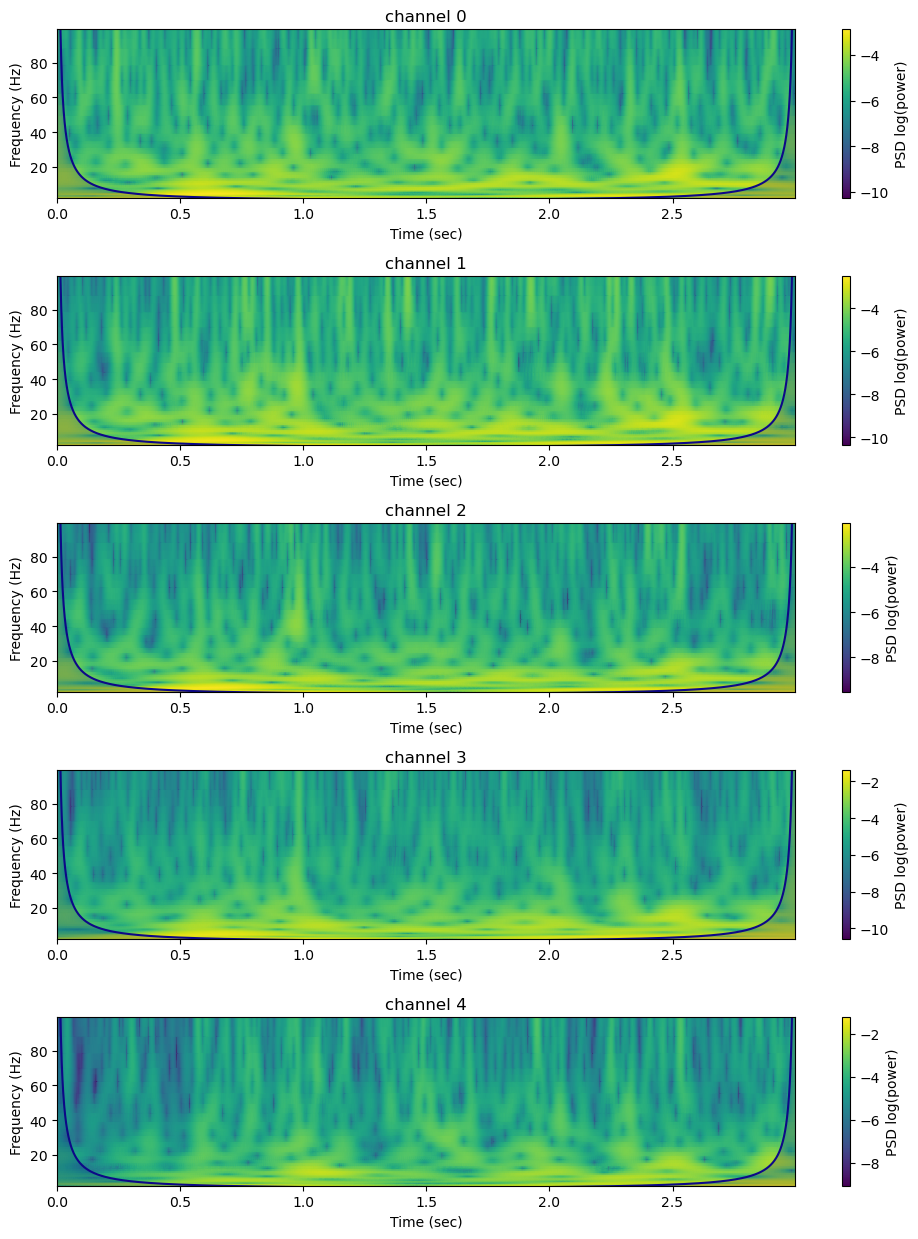

In [14]:
scalogram_params = params['scalogram_params']
remove_aperiodic = params['fooof_params'] if scalogram_params['remove_aperiodic'] else None
for dur in durations:
    print(dur)
    _, axs = plt.subplots(n_channel, 1, figsize=(10, 2.5 * n_channel))
    for i, ax in enumerate(axs):
        sxx = lfp_sxx[dur].isel(channel_id=i)
        channel_id = sxx.channel_id.values
        if remove_aperiodic is None:
            fooof_results = None
        else:
            sxx_tot = sxx.PSD.mean(dim='time')
            fooof_results, _ = plot.fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **remove_aperiodic)
        _ = plot.plot_spectrogram(sxx, remove_aperiodic=fooof_results,
                                  plt_log=scalogram_params['plt_log'],
                                  plt_range=params['fooof_params']['plt_range'],
                                  clr_freq_range=scalogram_params['clr_freq_range'], ax=ax)
        ax.set_title(f'channel {channel_id:d}')
    plt.tight_layout()
    plt.show()

### PSD of spike time histogram

In [37]:
durations = list(setting.duration_window.keys())
fs = pop_rspk.fs
psd_rspk = {}
rspk_sxx = {}
for dur in durations:
    tseg = setting.psd_segment_length[dur]
    # PSD
    time_window = 1000 * np.array(setting.duration_window[dur]) # ms
    spike_rate = pop_rspk.spike_rate.sel(time=slice(*time_window))
    f, pxx = ss.welch((spike_rate - spike_rate.mean(dim='time')).values, fs=fs, nperseg=int(tseg * fs))
    psd_rspk[dur] = xr.DataArray(pxx, coords={'population': pop_rspk.population.values, 'frequency': f})
    # CWT
    axis = pop_rspk.spike_rate.dims.index('time')
    rspk_sxx[dur] = plot.cwt_spectrogram_xarray(
        pop_rspk.spike_rate, fs, axis=axis, downsample_fs=params['scalogram_params']['downsample_fs'],
        channel_coords={'population': pop_rspk.population}, freq_range=(1 / tseg, np.inf)
    )

In [ ]:
plt_range = params['fooof_params']['plt_range']
fooof_params = dict(params['fooof_params'].items(), aperiodic_mode='fixed')
for dur in durations:
    print(dur)
    _, axs = plt.subplots(2 * len(layers), 2, figsize=(10, 2.5 * 2 * len(layers)))
    f = psd_rspk[dur].frequency.values
    plt_range = np.array(f[-1]) if plt_range is None else np.array(plt_range)
    if plt_range.size == 1:
        plt_range = [0., plt_range.item()]
    f_idx = (f >= plt_range[0]) & (f <= plt_range[1])
    for i, L in enumerate(layers):
        for j, M in enumerate(model_types):
            ax2 = axs[2 * i:2 * i + 2, j]
            pops = v1_pop_df.index[(v1_pop_df['layer'] == L) & (v1_pop_df['model_type'] == M)]
            for p in pops:
                psd = psd_rspk[dur].sel(population=p).values
                if not np.any(psd):
                    continue
                ax2[0].plot(f[f_idx], psd[f_idx], color=v1_pop_df.loc[p, 'color'], label=p)
                # plot residual
                fooof_results, _ = plot.fit_fooof(f, psd, report=False, plot=False, **fooof_params)
                res_psd, _ = plot.psd_residual(f, psd, fooof_results, plot=False)
                ax2[1].plot(f[f_idx], res_psd[f_idx], color=v1_pop_df.loc[p, 'color'], label=p)
            for ax in ax2:
                ax.set_xlim(plt_range)
                ax.legend(loc='upper right', framealpha=0.2)
                ax.set_xlabel('Frequency (Hz)')
            ax2[0].set_yscale('log')
            ax2[0].set_ylabel('Power')
            ax2[1].set_ylabel('PSD Residual')
    plt.tight_layout()
    plt.show()

In [23]:
scalogram_params = params['scalogram_params']
remove_aperiodic = fooof_params if scalogram_params['remove_aperiodic'] else None
for dur in durations:
    print(dur)
    _, axs = plt.subplots(len(layers), 2, figsize=(10, 2.5 * len(layers)))
    for i, L in enumerate(layers):
        for j, M in enumerate(model_types):
            ax = axs[i, j]
    for i, ax in enumerate(axs):
        sxx = lfp_sxx[dur].isel(channel_id=i)
        channel_id = sxx.channel_id.values
        if remove_aperiodic is None:
            fooof_results = None
        else:
            sxx_tot = sxx.PSD.mean(dim='time')
            fooof_results, _ = plot.fit_fooof(sxx_tot.frequency.values, sxx_tot.values, **remove_aperiodic)
        _ = plot.plot_spectrogram(sxx, remove_aperiodic=fooof_results,
                                  plt_log=scalogram_params['plt_log'],
                                  plt_range=params['fooof_params']['plt_range'],
                                  clr_freq_range=scalogram_params['clr_freq_range'], ax=ax)
        ax.set_title(f'channel {channel_id:d}')
    plt.tight_layout()
    plt.show()

<xarray.Dataset>
Dimensions:     (population: 34, frequency: 126)
Coordinates:
  * population  (population) <U11 'LIFe23' 'LIFe4' 'LIFe5' ... 'i6Pvalb' 'i6Sst'
  * frequency   (frequency) float64 0.0 2.0 4.0 6.0 ... 244.0 246.0 248.0 250.0
Data variables:
    PSD         (population, frequency) float64 0.001183 0.01639 ... 0.0245